In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from backtest_functions import *

### preprocess

In [2]:
path_to_folder = "C:/Users/phku0/Quant_Project"
df = pd.read_parquet(path_to_folder+'/data_processing/v3_cleaned.parquet')

df.rename({'month':'year_month'}, axis=1, inplace=True)
df['year'] = df['year_month'].dt.year
df['month'] = df['year_month'].dt.month

print(df.shape)
print(df.columns)

(872206, 42)
Index(['year_month', 'cusip', 'ratingOverall', 'ratingCareerOpportunities',
       'ratingCompensationAndBenefits', 'ratingCultureAndValues',
       'ratingSeniorLeadership', 'ratingWorkLifeBalance',
       'ratingDiversityAndInclusion', 'ratingBusinessOutlook', 'ratingCeo',
       'ratingRecommendToFriend', 'summary_length', 'pros_length',
       'cons_length', 'advice_length', 'summary_token_count',
       'pros_token_count', 'cons_token_count', 'advice_token_count',
       'summary_sentiment', 'pros_sentiment', 'cons_sentiment',
       'advice_sentiment', 'summary_token', 'pros_token', 'cons_token',
       'advice_token', 'innovative_llama', 'integrity_llama', 'quality_llama',
       'respect_llama', 'teamwork_llama', 'review_count', 'vol_forward_1m',
       'return_forward_1m', 'gsector', 'ggroup', 'gind', 'gsubind', 'year',
       'month'],
      dtype='object')


In [3]:
df = df.drop(columns=['summary_token', 'pros_token', 'cons_token', 'advice_token'])

<Axes: xlabel='year_month'>

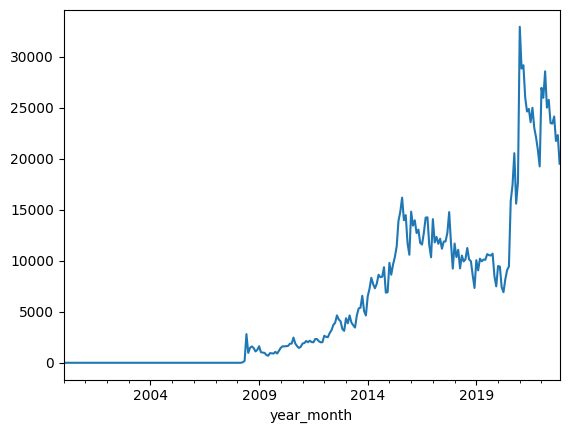

In [4]:
df.groupby('year_month')['review_count'].sum().plot()

In [5]:
df = df[df['year_month'] >= "2014-01"]

In [6]:
cols = ['ratingOverall', 'ratingCareerOpportunities', 'ratingCompensationAndBenefits', 
        'ratingCultureAndValues', 'ratingSeniorLeadership', 'ratingWorkLifeBalance', 
        'ratingDiversityAndInclusion', 'ratingBusinessOutlook', 'ratingCeo', 
        'ratingRecommendToFriend', 'summary_length', 'pros_length', 'cons_length', 
        'advice_length', 'summary_token_count', 'pros_token_count', 'cons_token_count', 
        'advice_token_count', 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 
        'advice_sentiment', 'innovative_llama', 'integrity_llama', 'quality_llama', 
        'respect_llama', 'teamwork_llama']

for col in cols:
  df[col] = np.where(df.review_count >= 15, df[col], np.NaN)

In [7]:
df.drop(columns='ratingDiversityAndInclusion', inplace=True)

In [8]:
# df['gsector'] = df['gsector'].astype('category')
# df['ggroup'] = df['ggroup'].astype('category')
# df['gind'] = df['gind'].astype('category')
# df['gsubind'] = df['gsubind'].astype('category')

df['gsector'] = df['gsector'].astype('float')
df['ggroup'] = df['ggroup'].astype('float')
df['gind'] = df['gind'].astype('float')
df['gsubind'] = df['gsubind'].astype('float')

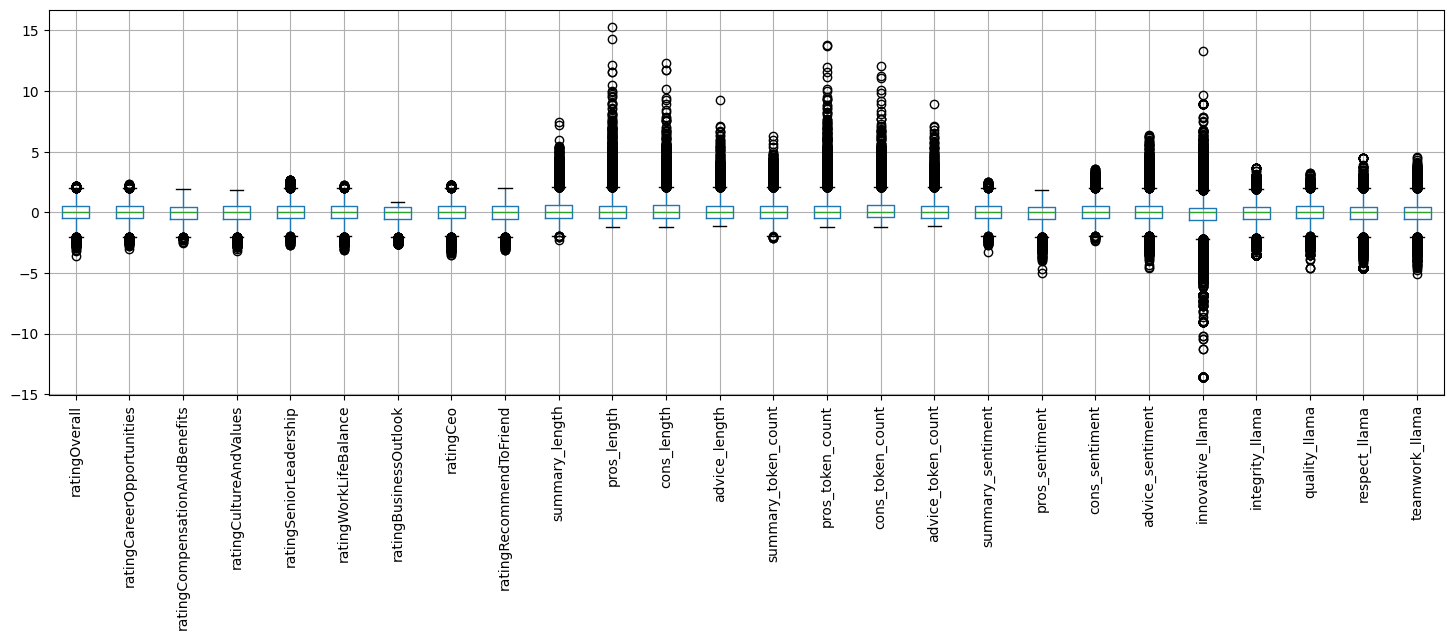

In [9]:
cols_features = ['ratingOverall', 'ratingCareerOpportunities',
                 'ratingCompensationAndBenefits', 'ratingCultureAndValues',
                 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
                 'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
                 'summary_length', 'pros_length', 'cons_length', 'advice_length',
                 'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count',
                 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
                 'innovative_llama', 'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

scaler = RobustScaler()
df2 = df.copy()
df2[cols_features] = scaler.fit_transform(df2[cols_features])

df2[cols_features].boxplot(figsize = (18,5))
plt.xticks(rotation=90)
plt.show()

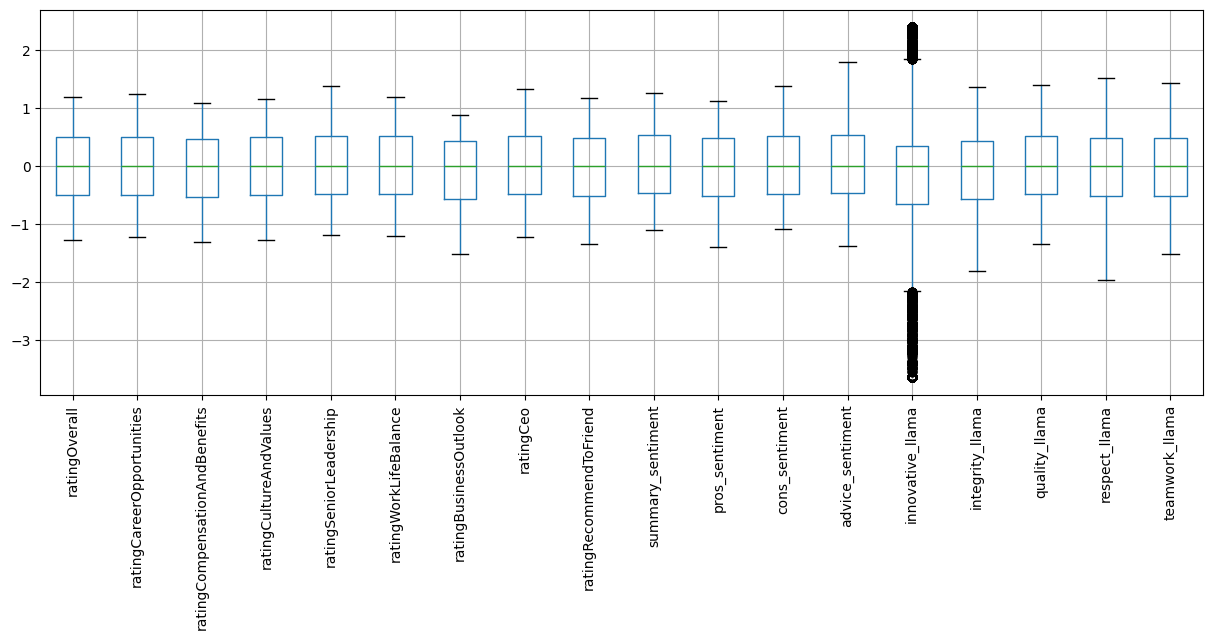

In [10]:
cols_to_scale = ['ratingOverall', 'ratingCareerOpportunities',
                 'ratingCompensationAndBenefits', 'ratingCultureAndValues',
                 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
                 'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
                 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
                 'innovative_llama', 'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

lower_bound = df[cols_features].quantile(0.05)
upper_bound = df[cols_features].quantile(0.95)
df[cols_to_scale] = df[cols_to_scale].clip(lower=lower_bound, upper=upper_bound, axis=1)

scaler = RobustScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

df[cols_to_scale].boxplot(figsize = (15,5))
plt.xticks(rotation=90)
plt.show()

In [11]:
df.drop(columns='innovative_llama', inplace=True)

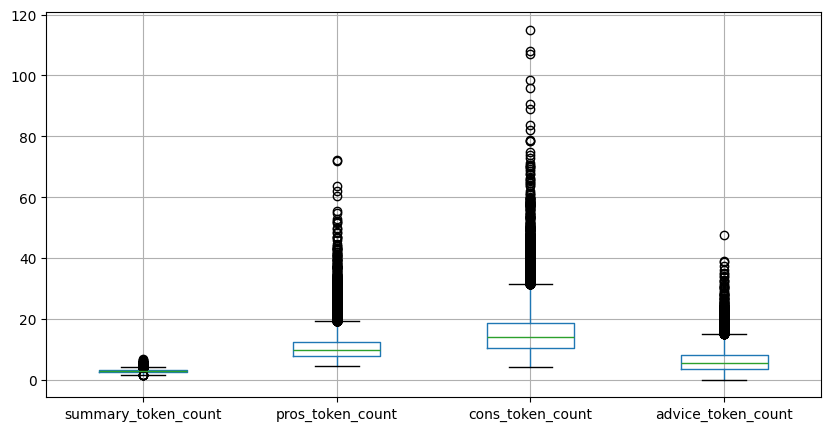

In [12]:
cols_no_scale = ['summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count']
# these outliers are useful

df[cols_no_scale].boxplot(figsize = (10,5))
plt.xticks(rotation=0)
plt.show()

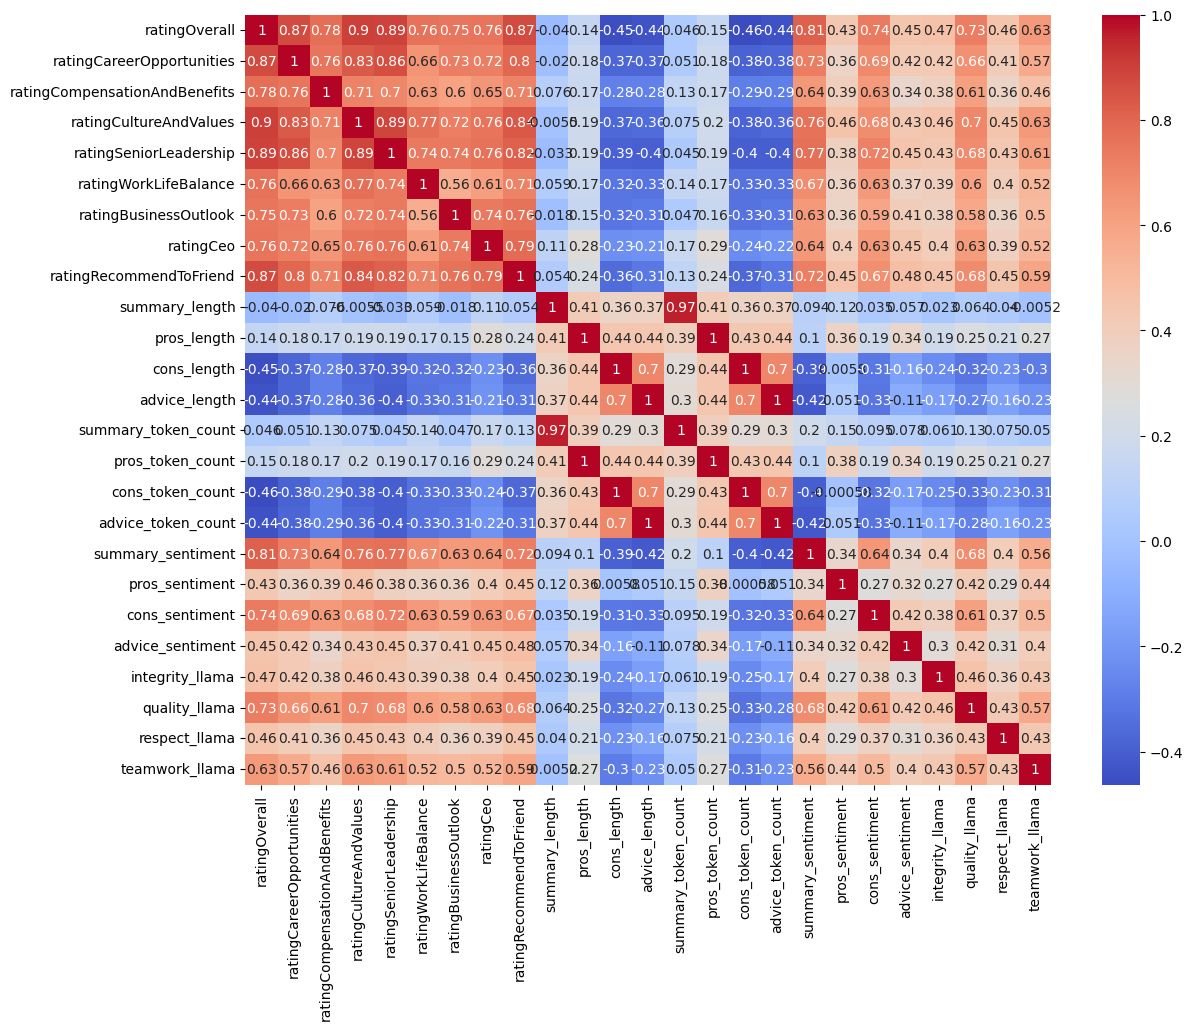

In [13]:
cols = ['ratingOverall', 'ratingCareerOpportunities',
        'ratingCompensationAndBenefits', 'ratingCultureAndValues',
        'ratingSeniorLeadership', 'ratingWorkLifeBalance',
        'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
        'summary_length', 'pros_length', 'cons_length', 'advice_length',
        'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count',
        'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
        'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

corr_matrix = df[cols].corr()
plt.figure(figsize=(13, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [14]:
df.drop(columns=['summary_length', 'pros_length', 'cons_length', 'advice_length'], inplace=True)

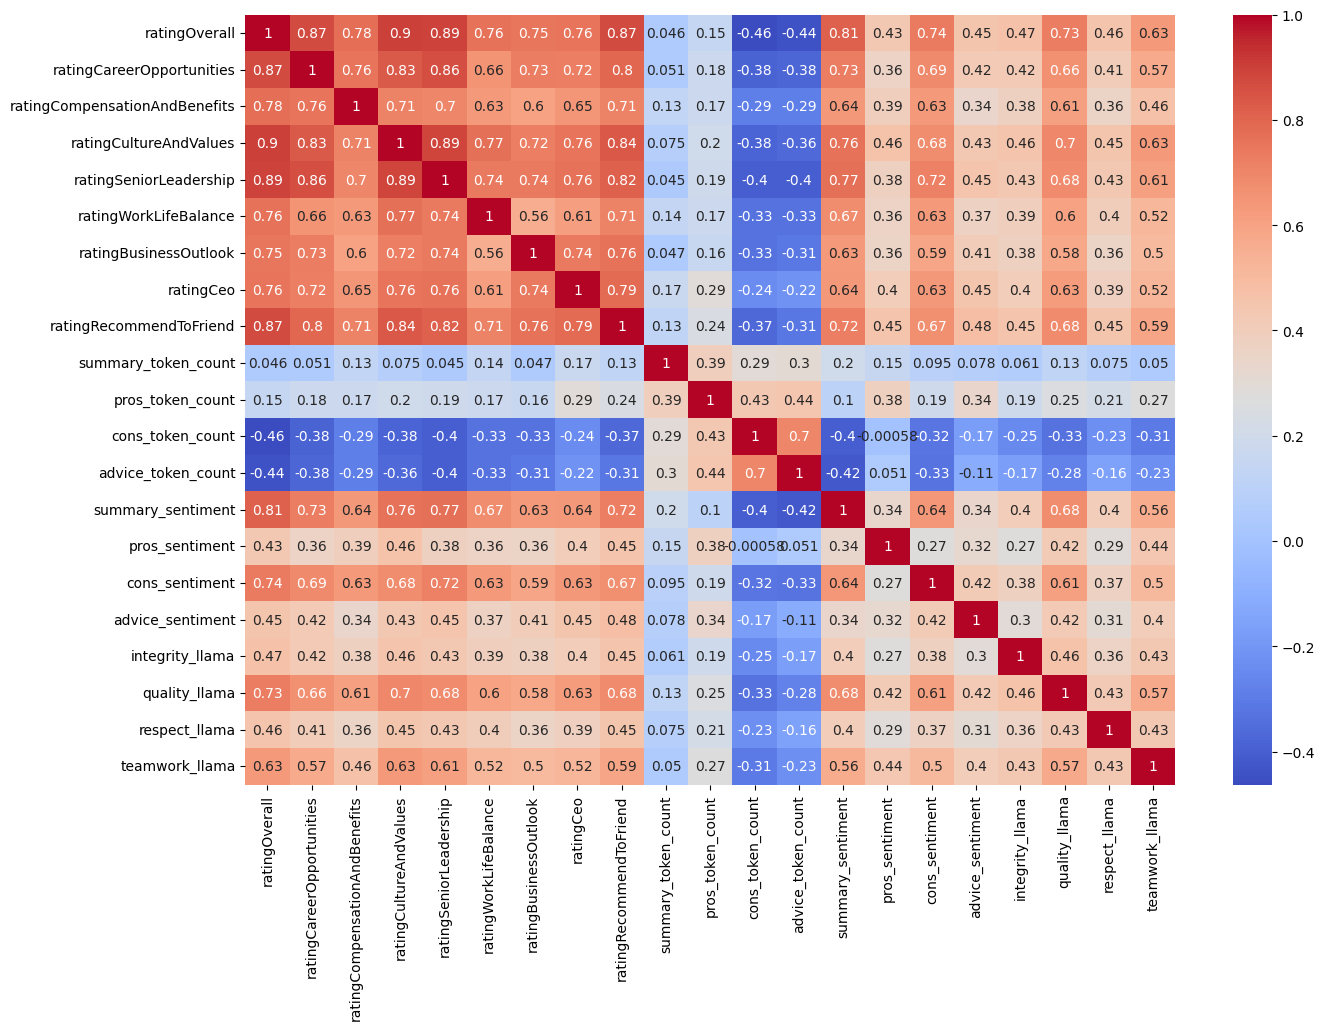

In [15]:
cols_features = ['ratingOverall', 'ratingCareerOpportunities',
                 'ratingCompensationAndBenefits', 'ratingCultureAndValues',
                 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
                 'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
                 'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count',
                 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
                 'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

corr_matrix = df[cols_features].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

### weighting

In [16]:
cols = ['ratingOverall', 'ratingCareerOpportunities', 'ratingCompensationAndBenefits', 
        'ratingCultureAndValues', 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
        'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
        'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
        'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

df['ratings'] = df[cols].mean(axis=1)
df.drop(columns=cols, axis=1, inplace=True)

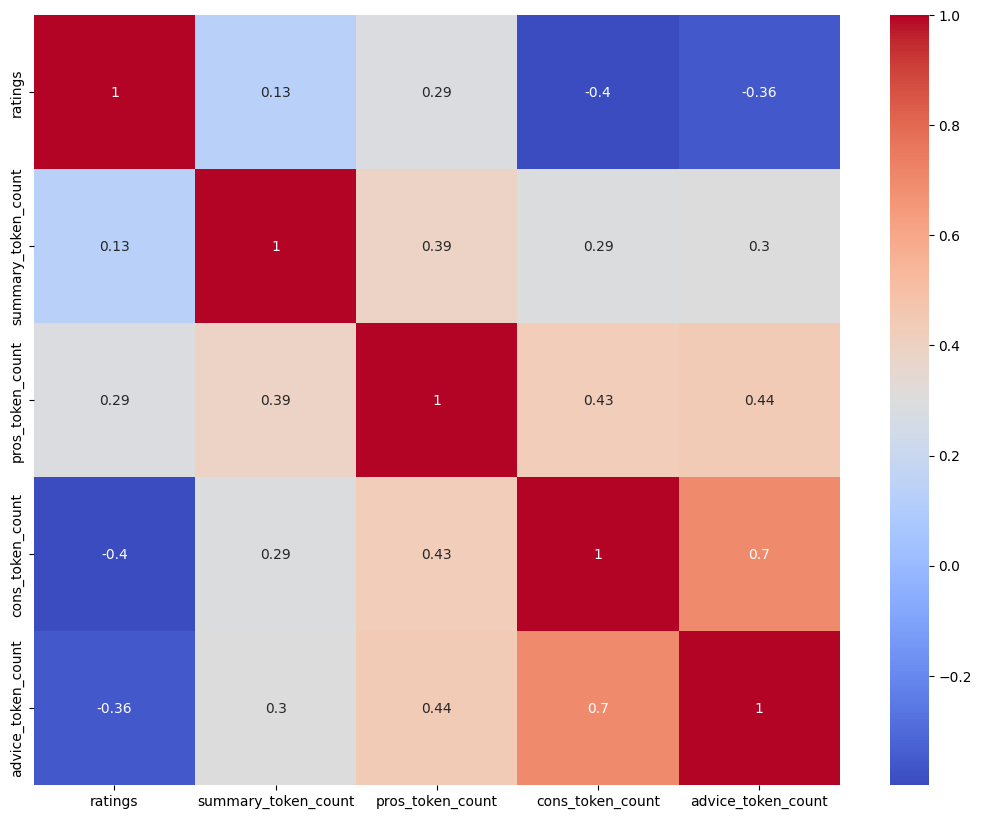

In [17]:
cols_features = ['ratings',
                 'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count']

corr_matrix = df[cols_features].corr()
plt.figure(figsize=(13, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

### smooth

In [18]:
cols_features = ['ratings',
                 'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count']

for feature in tqdm(cols_features):
  factor_xnd = df[['year_month', 'cusip', feature]].pivot(index='year_month', columns='cusip', values=feature)
  factor_xnd = neutralise_by_group(factor_xnd, "gsubind")
  factor_xnd = factor_xnd.rolling(12, min_periods=1).mean()
  factor_long = factor_xnd.reset_index().melt(id_vars='year_month', var_name='cusip', value_name=feature)

  df.drop(columns=feature, inplace=True)
  df = df.merge(factor_long, on=['year_month', 'cusip'], how='left', suffixes=('', '_transformed'))
  df.rename(columns={feature + '_transformed': feature}, inplace=True)

100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


In [19]:
df.head(2)

,year_month,cusip,review_count,vol_forward_1m,return_forward_1m,gsector,ggroup,gind,gsubind,year,month,ratings,summary_token_count,pros_token_count,cons_token_count,advice_token_count
0,2014-01,10055710,0,1532800.0,0.136529,30.0,3020.0,302010.0,30201010.0,2014,1,NaN,NaN,NaN,NaN,NaN
1,2014-02,10055710,1,1580543.0,0.033708,30.0,3020.0,302010.0,30201010.0,2014,2,NaN,NaN,NaN,NaN,NaN


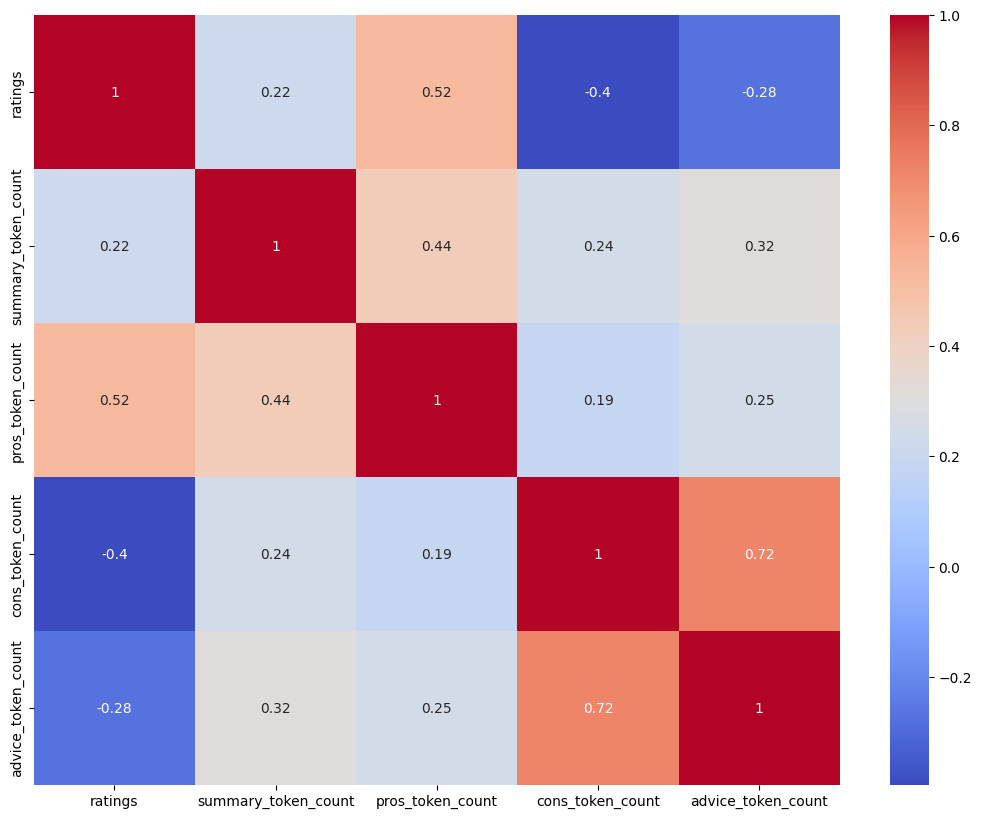

In [20]:
cols_features = ['ratings',
                 'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count']

corr_matrix = df[cols_features].corr()
plt.figure(figsize=(13, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

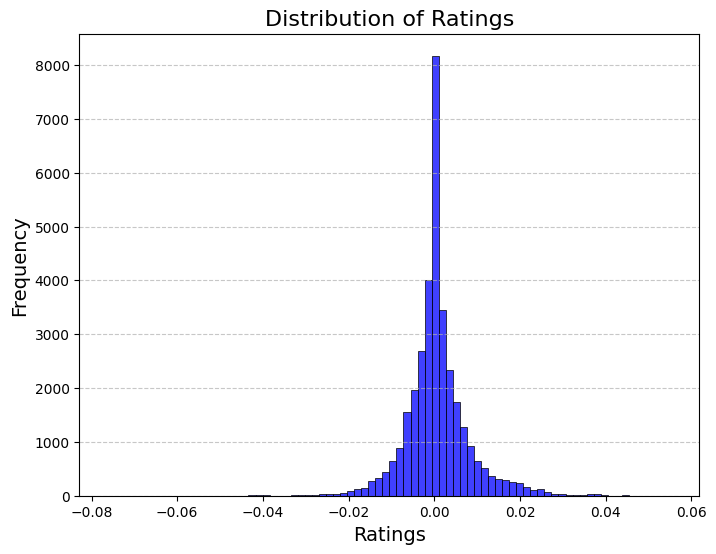

In [21]:
plt.figure(figsize=(8, 6))
sns.histplot(df['ratings'], bins=80, color='blue', edgecolor='black')

plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Ratings', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [22]:
df.head()

,year_month,cusip,review_count,vol_forward_1m,return_forward_1m,gsector,ggroup,gind,gsubind,year,month,ratings,summary_token_count,pros_token_count,cons_token_count,advice_token_count
0,2014-01,10055710,0,1532800.0,0.136529,30.0,3020.0,302010.0,30201010.0,2014,1,NaN,NaN,NaN,NaN,NaN
1,2014-02,10055710,1,1580543.0,0.033708,30.0,3020.0,302010.0,30201010.0,2014,2,NaN,NaN,NaN,NaN,NaN
2,2014-03,10055710,0,1197393.0,0.005354,30.0,3020.0,302010.0,30201010.0,2014,3,NaN,NaN,NaN,NaN,NaN
3,2014-04,10055710,2,1681607.0,-0.128557,30.0,3020.0,302010.0,30201010.0,2014,4,NaN,NaN,NaN,NaN,NaN
4,2014-05,10055710,1,1236788.0,0.042488,30.0,3020.0,302010.0,30201010.0,2014,5,NaN,NaN,NaN,NaN,NaN


### backtest

Overall Annual Sharpe Ratio: 0.2421054579500148
--------------
Yearly Sharpe Ratio
year_month
2014    0.858947
2015    2.036794
2016   -0.387866
2017    2.290285
2018    1.295273
2019    1.495346
2020   -0.483046
2021   -1.055603
2022   -0.445843
dtype: float64
--------------
Yearly Return (%)
year_month
2014    2.166862
2015    5.143892
2016   -0.997183
2017    4.680205
2018    4.920994
2019    6.606176
2020   -5.014777
2021   -6.216330
2022   -1.283398
dtype: float64


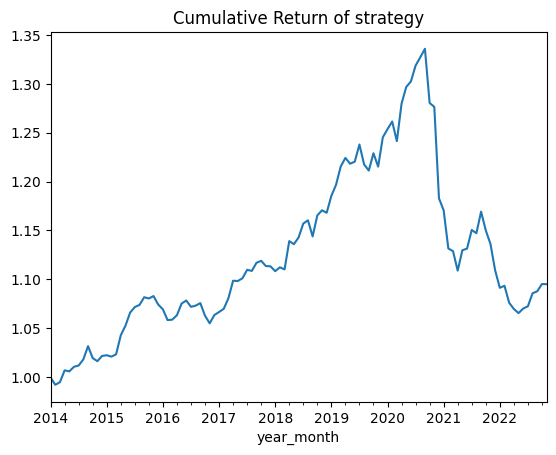

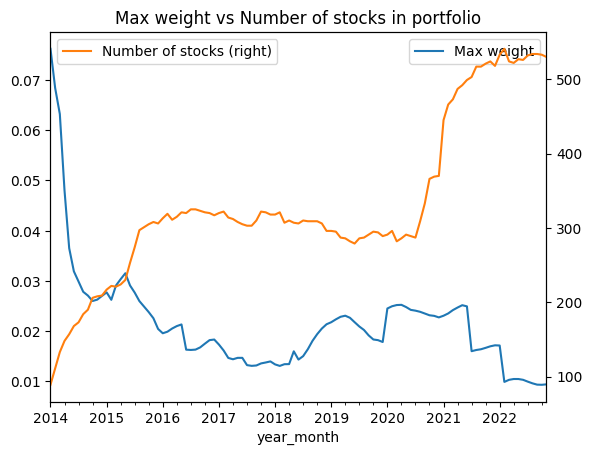

In [23]:
return_xnd = df[['year_month','cusip','return_forward_1m']].pivot(index = 'year_month', columns = 'cusip', values = 'return_forward_1m')

factor = 'ratings'

factor_xnd = df[['year_month','cusip',factor]].pivot(index = 'year_month', columns = 'cusip', values = factor)
factor_xnd = neutralise_by_group(factor_xnd, "gsubind")
factor_xnd = factor_xnd.rolling(3, min_periods = 1).mean()

portfolio_return = run_backtest(return_xnd, factor_xnd)
plot_backtest(portfolio_return)
plot_weights(factor_xnd)

### correlations

In [24]:
correlations = df[['ratings',
       'summary_token_count',
       'pros_token_count', 'cons_token_count', 'advice_token_count',
       'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'review_count',
       'return_forward_1m'
]].corr()['return_forward_1m'].sort_values(ascending=False)

print(correlations)

KeyError: "['summary_sentiment', 'pros_sentiment', 'cons_sentiment'] not in index"

In [ ]:
cols = ['ratings',
       'summary_token_count',
       'pros_token_count', 'cons_token_count', 'advice_token_count',
       'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'review_count']

for col in cols:
  spearman_corr = df[col].corr(df['return_forward_1m'], method='spearman')
  print(col, spearman_corr)

ratings 0.017143754951708983
summary_token_count 0.0020369224070806166
pros_token_count 0.00043346085592055116
cons_token_count -0.019211121243411497
advice_token_count -0.01126826022651917
summary_sentiment 0.01754979997721766
pros_sentiment 0.015316318313153264
cons_sentiment 0.011108034809532319
review_count 0.034464188942854905
